In [5]:
import os
import numpy as np
import pandas as pd
# import sklearn.linear_model as sklm
# import sklearn.model_selection as skms
# import sklearn.feature_selection
# import sklearn.pipeline
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Import our custom functions
from load_data import load_data 

In [2]:
# Load training an validation data.
# x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)
# y is a dataframe of index, class_name and class_id
x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')

for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

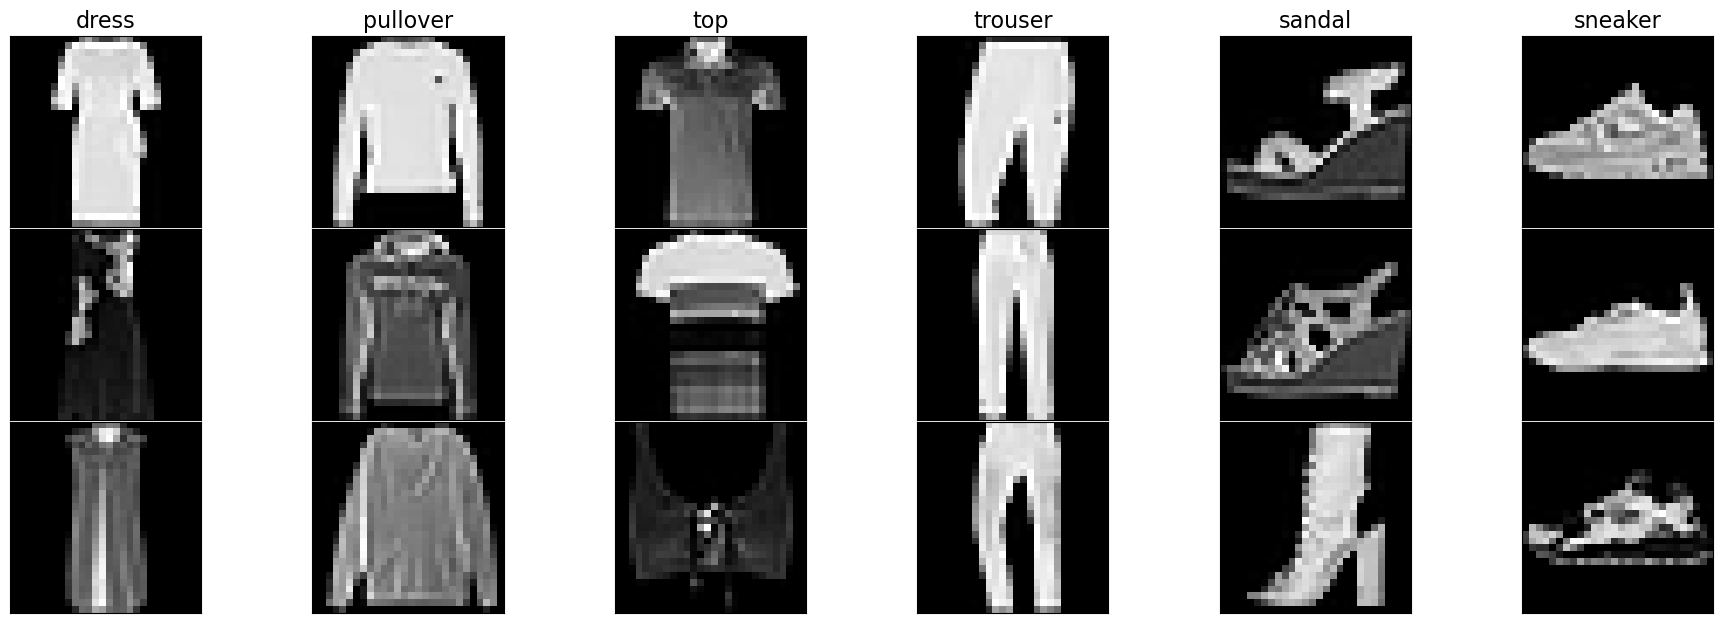

In [14]:
# Plot a random image from the validation data for each file
# prng = np.random.RandomState(0)
prng = np.random.RandomState()
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = y_va_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = x_va[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();